# Coastal Kelvin Wave Test Case

simulating a coastal kelvin wave

In [5]:
CODE_ROOT = pwd() * "/../"

"/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/development_notebooks/../"

In [6]:
include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")


using PyPlot
using PyCall

animation  = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")


using LinearAlgebra # for norm()

using Printf # for print formatting

In [28]:
include(CODE_ROOT * "mode_init/MPAS_OceanHalos.jl") 

moveArrays! (generic function with 1 method)

In [7]:
import CUDA

In [51]:
using DelimitedFiles

In [89]:
256^2 / 4

16384.0

In [90]:
nCellsX = 128

mpasOcean = MPAS_Ocean(
                CODE_ROOT * "MPAS_O_Shallow_Water/ConvergenceStudyMeshes/CoastalKelvinWave",
                "culled_mesh_$(nCellsX)x$(nCellsX).nc", "mesh_$(nCellsX)x$(nCellsX).nc", periodicity="NonPeriodic_x")

In [90]:
# nprocs = 2048

# partitiondir = CODE_ROOT * "scaling_test/graphparts/$(nCellsX)x$(nCellsX)/"
# partitionfile = partitiondir * "graph.info.part.$nprocs"
# partitions = dropdims(readdlm(partitionfile), dims=2)

# worldrank = 1
# halowidth = 1

# fig, ax, _ = heatMapMesh(mpasOcean, partitions, cmap="nipy_spectral")
# display(fig)

# hist(partitions, bins=nprocs)

#     mycells = findall(proc -> proc == worldrank-1, partitions)

#     cellsOnCell = Array{Int64,2}(replace(readdlm(partitiondir * "graph.info")[2:end,:], ""=>0))

#     (haloCells = grow_halo(cellsOnCell, mycells, halowidth))

#     cellsFromChunk = Dict{Int64, Array}()
#     for iCell in haloCells
#         chunk = partitions[iCell] + 1
#         if chunk in keys(cellsFromChunk)
#             push!(cellsFromChunk[chunk], iCell)
#         else
#             cellsFromChunk[chunk] = [iCell]
#         end
#     end

#     myCells     = union(mycells, haloCells)
    
#     mpasOcean = MPAS_Ocean(
#                 CODE_ROOT * "MPAS_O_Shallow_Water/ConvergenceStudyMeshes/CoastalKelvinWave",
#                 "culled_mesh_32x32.nc", "mesh_32x32.nc", periodicity="NonPeriodic_x", cells=myCells)
#     mpasOcean.nCells


In [30]:
meanCoriolisParameterf = sum(mpasOcean.fEdge) / length(mpasOcean.fEdge)

0.00010000000000000007

In [31]:
meanFluidThicknessH = sum(mpasOcean.bottomDepth)/length(mpasOcean.bottomDepth)

1000.0

In [32]:
c = sqrt(mpasOcean.gravity*meanFluidThicknessH)

98.99494936611666

In [33]:
rossbyRadiusR = c/meanCoriolisParameterf

989949.4936611658

## the lateral profile of the kelvin wave, can be any function

In [34]:
lYedge = maximum(mpasOcean.yEdge) - minimum(mpasOcean.yEdge)

4.330127018922193e6

In [35]:
function lateralProfileGaussian(y)
    mu = lYedge/2#20.0e5
    sigma = 3.0e5
    return 1e-3*exp(- (y .% lYedge -mu)^2 / sigma^2) #* cos(y*5.0e-6)
end

lateralProfileGaussian (generic function with 1 method)

In [36]:
function lateralProfilePeriodic(y)
    return 1e-3*cos(y/lYedge * 4 * pi)
end

lateralProfilePeriodic (generic function with 1 method)

In [37]:
lateralProfile = lateralProfilePeriodic

lateralProfilePeriodic (generic function with 1 method)

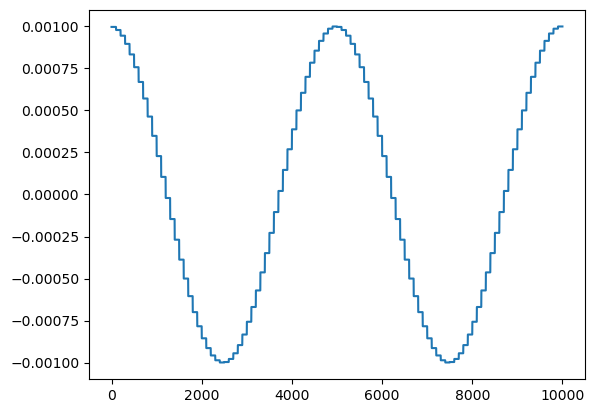

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f754607a4c0>

In [38]:
plot(lateralProfile.(mpasOcean.yCell))

## set the velocity and ssh to be a kelvin wave

In [39]:
function kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t=0)
    v = sqrt(mpasOcean.gravity*meanFluidThicknessH) * lateralProfile(mpasOcean.yEdge[iEdge] .+ c*t) * exp(-mpasOcean.xEdge[iEdge]/rossbyRadiusR)
    return v*sin(mpasOcean.angleEdge[iEdge])
end

kelvinWaveExactNormalVelocity (generic function with 2 methods)

In [40]:
function kelvinWaveExactSSH(mpasOcean, iCell, t=0)
    return - meanFluidThicknessH * lateralProfile(mpasOcean.yCell[iCell] .+ c*t) * exp(-mpasOcean.xCell[iCell]/rossbyRadiusR)
end

kelvinWaveExactSSH (generic function with 2 methods)

In [41]:
function kelvinWaveExactSolution!(mpasOcean, t=0)
    for iCell in 1:mpasOcean.nCells
        mpasOcean.sshCurrent[iCell] = kelvinWaveExactSSH(mpasOcean, iCell, t)
    end
    
    for iEdge in 1:mpasOcean.nEdges
        mpasOcean.normalVelocityCurrent[iEdge] = kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t)
    end
end

kelvinWaveExactSolution! (generic function with 2 methods)

In [42]:
function boundaryCondition!(mpasOcean, t)
    for iEdge in 1:mpasOcean.nEdges
        if mpasOcean.boundaryEdge[iEdge] == 1.0
            mpasOcean.normalVelocityCurrent[iEdge] = kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t)
        end
    end
    
end

boundaryCondition! (generic function with 1 method)

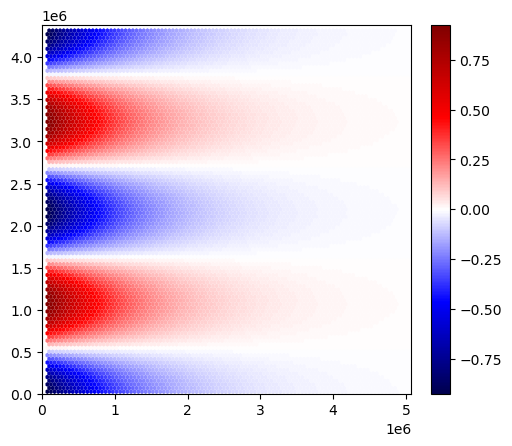

In [43]:
kelvinWaveExactSolution!(mpasOcean)

fig, ax, _, _ = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
display(fig)

# Simulate wave

In [44]:
sqrt(mpasOcean.gravity*meanFluidThicknessH)

98.99494936611666

In [45]:
mpasOcean.dcEdge[1] / mpasOcean.dt

989.9494936611826

In [46]:
T = 25000

25000

In [47]:
T/mpasOcean.dt

494.9747468305913

In [48]:
nFrames = 50

sshOverTime = zeros(Float64, (nFrames, mpasOcean.nCells))

saveInterval = Int(round(T/mpasOcean.dt / nFrames))

t = 0

for i in 1:nFrames
    for j in 1:saveInterval
        
        calculate_normal_velocity_tendency!(mpasOcean)
    
        update_normal_velocity_by_tendency!(mpasOcean)

        
        boundaryCondition!(mpasOcean, t)

        
        calculate_ssh_tendency!(mpasOcean)

        update_ssh_by_tendency!(mpasOcean)

        t += mpasOcean.dt
    end
    sshOverTime[i,:] .= mpasOcean.sshCurrent[:]
end

In [49]:
nFrames*saveInterval*mpasOcean.dt

25253.813613804858

## animate simulation

In [50]:
cMax = maximum(abs.(sshOverTime))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f754df13070>

In [51]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

In [55]:
using BenchmarkTools

In [59]:
@benchmark begin
    t = 0
    for j in 1:24

        calculate_normal_velocity_tendency!(mpasOcean)

        update_normal_velocity_by_tendency!(mpasOcean)


        boundaryCondition!(mpasOcean, t)


        calculate_ssh_tendency!(mpasOcean)

        update_ssh_by_tendency!(mpasOcean)

        t += mpasOcean.dt
    end
end samples=100 seconds=200

BechmarkTools.Trial: 96 samples with 1 evaluations.
 Range (min … max):  2.046 s …   2.179 s  ┊ GC (min … max): 6.14% … 6.45%
 Time  (median):     2.093 s              ┊ GC (median):    6.18%
 Time  (mean ± σ):   2.095 s ± 28.229 ms  ┊ GC (mean ± σ):  6.23% ± 0.12%

             █▆▄▆▄      ▂▆▆   ▂  ▂       ▂                   
  ▆▄▁▄▆▁▄▄▁▆▆█████▄▄▆▁▄████▁▄▁█▆▁█▁▆▄▄▆▄▄█▁▁▁▄▄▁▁▁▆▁▁▄▁▁▄▁▄ ▁
  250 s          Histogram: frequency by time        2.17 s <

 Memory estimate: 1.65 GiB, allocs estimate: 94695448.

In [60]:
mpasOcean.nCells

10000

In [70]:
@benchmark begin
    calculate_normal_velocity_tendency!(mpasOcean)

    update_normal_velocity_by_tendency!(mpasOcean)


    boundaryCondition!(mpasOcean, 0)


    calculate_ssh_tendency!(mpasOcean)

    update_ssh_by_tendency!(mpasOcean)
end

BechmarkTools.Trial: 59 samples with 1 evaluations.
 Range (min … max):  83.490 ms … 92.786 ms  ┊ GC (min … max): 4.76% … 5.29%
 Time  (median):     84.710 ms              ┊ GC (median):    4.94%
 Time  (mean ± σ):   86.022 ms ±  2.407 ms  ┊ GC (mean ± σ):  6.24% ± 2.09%

   ▁   █▁  █▃                                                  
  ▇█▇▇▄██▇▄██▁▄▄▁▄▄▄▁▄▁▄▁▄▁▁▁▁▁▄▁▁▁▁▁▁▇▄▁▁▁▁▁▇▄▇▄▁▄▇▁▁▄▁▄▇▁▁▄ ▁
  83.5 ms         Histogram: frequency by time        90.6 ms <

 Memory estimate: 70.53 MiB, allocs estimate: 3944875.

In [71]:
@benchmark begin
    calculate_normal_velocity_tendency!(mpasOcean)

    update_normal_velocity_by_tendency!(mpasOcean)


#     boundaryCondition!(mpasOcean, 0)


    calculate_ssh_tendency!(mpasOcean)

    update_ssh_by_tendency!(mpasOcean)
end

BechmarkTools.Trial: 61 samples with 1 evaluations.
 Range (min … max):  81.005 ms … 89.452 ms  ┊ GC (min … max): 4.85% … 4.76%
 Time  (median):     82.395 ms              ┊ GC (median):    4.92%
 Time  (mean ± σ):   83.324 ms ±  2.361 ms  ┊ GC (mean ± σ):  6.08% ± 1.97%

  ▆▆▁█ ▁▁        ▃                 ▁       ▁                   
  ████▄██▇▁▄▇▄▇▄▄█▄▁▁▄▁▁▁▄▄▁▁▁▁▁▁▁▄█▁▁▇▁▁▄▁█▁▄▁▁▁▁▁▇▁▁▄▁▄▁▁▁▄ ▁
  81 ms           Histogram: frequency by time        88.8 ms <

 Memory estimate: 68.54 MiB, allocs estimate: 3845314.

In [72]:
@benchmark begin
    forward_backward_step!(mpasOcean)
end

BechmarkTools.Trial: 62 samples with 1 evaluations.
 Range (min … max):  79.887 ms … 89.078 ms  ┊ GC (min … max): 4.84% … 4.84%
 Time  (median):     81.021 ms              ┊ GC (median):    4.98%
 Time  (mean ± σ):   81.931 ms ±  2.107 ms  ┊ GC (mean ± σ):  6.09% ± 1.98%

   █▆                                                          
  ▇██▆▇▇▁▁▇▄▄▆▄▄▄▁▄▄▆▁▁▄▁▁▄▁▁▄▄▁▁▁▄▁▁▁▁▁▄▄▁▆▇▁▆▁▆▇▁▁▁▁▄▁▁▁▁▁▄ ▁
  79.9 ms         Histogram: frequency by time        86.1 ms <

 Memory estimate: 68.54 MiB, allocs estimate: 3845314.

# show exact solution

In [27]:
sshOverTimeExact = zeros(Float64, (nFrames, mpasOcean.nCells))

t = 0

for i in 1:nFrames
    t += saveInterval*mpasOcean.dt
    kelvinWaveExactSolution!(mpasOcean, t)
    sshOverTimeExact[i,:] .= mpasOcean.sshCurrent[:]
end

In [28]:
fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTimeExact[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTimeExact[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7fb70f3c3eb0>

In [29]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

# difference between exact and numerical solution

In [30]:
fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTimeExact[1,:], cMin=-cMax/100, cMax=cMax/100)

function nextFrame(i)
    col.set_array(sshOverTimeExact[i+1,:] - sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7fb70e7d7610>

In [31]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

In [32]:
maximum(abs.(sshOverTimeExact[:,:] - sshOverTime[:,:]))

0.007767851019004457

In [33]:
maximum(abs.(sshOverTimeExact))

0.8883580373228464

# GPU time!

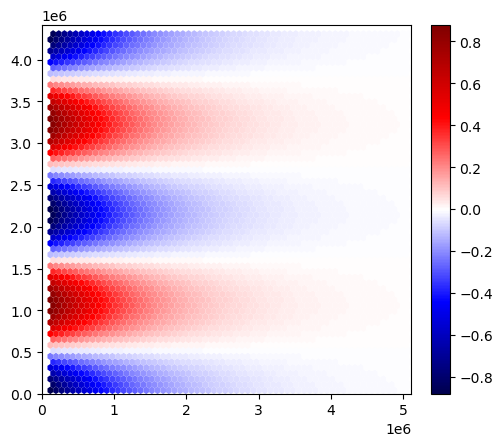

In [23]:
moveArrays!(mpasOcean, Array)
kelvinWaveExactSolution!(mpasOcean)

fig, ax, _, _ = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
display(fig)

In [24]:
# function lateralProfileCUDAKernel(y, edges)
#     iEdge = (CUDA.blockIdx().x - 1) * CUDA.blockDim().x + CUDA.threadIdx().x
#     edges[iEdge] = 1e-3*cos(y/lYedge * 4 * pi)
#     return
# end
function lateralProfilePeriodicCUDA(y, lYedge)
    return 1e-3*CUDA.cos(y/lYedge * 4 * CUDA.pi)
end

lateralProfilePeriodicCUDA (generic function with 1 method)

In [25]:
function boundaryConditionCUDAKernel!(nEdges, boundaryEdge, gravity, H, lateralProfile,
                                        yEdge, lYedge, xEdge, R, normalVelocityCurrent,
                                        angleEdge, t)
    iEdge = (CUDA.blockIdx().x - 1) * CUDA.blockDim().x + CUDA.threadIdx().x
    if iEdge <= nEdges
        if boundaryEdge[iEdge] == 1
            c = CUDA.sqrt(gravity * H)
            v = c * lateralProfile(yEdge[iEdge] .+ c*t, lYedge) * CUDA.exp(-xEdge[iEdge]/R)
            normalVelocityCurrent[iEdge] = v*CUDA.sin(angleEdge[iEdge])
        end
    end
    
    return
end
function boundaryConditionCUDA!(mpasOcean, t)
    CUDA.@cuda blocks=cld(mpasOcean.nEdges, 1024) threads=1024 maxregs=64 boundaryConditionCUDAKernel!(
        mpasOcean.nEdges, mpasOcean.boundaryEdge, mpasOcean.gravity, meanFluidThicknessH, lateralProfilePeriodicCUDA,
        mpasOcean.yEdge, lYedge, mpasOcean.xEdge, rossbyRadiusR, mpasOcean.normalVelocityCurrent, 
        mpasOcean.angleEdge, t
    )
end

boundaryConditionCUDA! (generic function with 1 method)

# Simulate wave (GPU)

In [26]:
nFrames = 50

sshOverTime = zeros(Float64, (nFrames, mpasOcean.nCells))

saveInterval = Int(round(T/mpasOcean.dt / nFrames))

t = 0

moveArrays!(mpasOcean, CUDA.CuArray)

for i in 1:nFrames
    for j in 1:saveInterval
        
        calculate_normal_velocity_tendency_cuda!(mpasOcean)
    
        update_normal_velocity_by_tendency_cuda!(mpasOcean)

        
        boundaryConditionCUDA!(mpasOcean, t)

        
        calculate_ssh_tendency_cuda!(mpasOcean)

        update_ssh_by_tendency_cuda!(mpasOcean)

        t += mpasOcean.dt
    end
    sshOverTime[i,:] .= mpasOcean.sshCurrent[:]
end

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007f75e1539f90.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArrays /home/rrs/.julia/packages/GPUArrays/8dzSJ/src/host/indexing.jl:56


## animate simulation

In [27]:
cMax = maximum(abs.(sshOverTime))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f754e690850>

In [28]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>